# Create User Network
This script creates a network from user posts

## Imports

In [81]:
import sqlite3
from pathlib import Path
from scraping import create_connection
import pandas as pd
import numpy as np
import networkx as nx

## File Locations

In [4]:
p = Path.cwd()
path_parent = p.parents[0]

In [75]:
db = "netmums-merged.db"
path_db = str(path_parent / "database" / db)
path_network_data = path_parent / "clean_data" / "network"
conn = create_connection(path_db)

In [26]:
network_sql = """
    SELECT
        COUNT(*) AS n_posts,
        f.id,
        f.name,
        p.user_url
    FROM posts AS p
    LEFT JOIN threads AS t
    ON t.id=p.thread_id
    LEFT JOIN subforums AS s
    ON s.id=t.subforum_id
    LEFT JOIN forums AS f
    ON f.id=s.forum_id
    WHERE p.user_url!="Anonymous"
    GROUP BY
        p.user_url,
        f.id
"""

In [37]:
network = pd.read_sql(network_sql, conn)

In [88]:
network[['id','name']].drop_duplicates()

,id,name
0,17,Life
1,21,Other chat
2,2,Becoming a mum: TTC
3,3,Becoming a mum: pregnancy
4,9,Drop-In Clinic
5,18,Local chat and make friends
10,1,"Product tests, sponsored chat and competitions"
12,5,Being a mum
14,11,Family food and recipes
16,25,Travel


In [38]:
network.head()

,n_posts,id,name,user_url
0,1,17,Life,01smith-c
1,1,21,Other chat,01smith-c
2,14,2,Becoming a mum: TTC,0407nc
3,16,3,Becoming a mum: pregnancy,0407nc
4,1,9,Drop-In Clinic,0407nc


In [99]:
node_1 = []
node_2 = []
weight = []
for forum_id_1 in network['id'].unique():
    for forum_id_2 in network['id'].unique():
        node_1.append(forum_id_1)
        node_2.append(forum_id_2)
        if forum_id_1 != forum_id_2:
            network_1 = network.loc[network['id']==forum_id_1].copy()
            network_2 = network.loc[network['id']==forum_id_2].copy()
            overlap = network_1.loc[network_1['user_url'].isin(network_2['user_url'])]
            weight.append(overlap.shape[0])
        elif forum_id_1 == forum_id_2:
            weight.append(np.NaN)
edge_df = pd.DataFrame({'node_1': node_1, 'node_2': node_2, 'weight': weight})
edge_df = edge_df.sort_values(by=['node_1', 'node_2'])
# edge_df.to_csv(path_network_data / "forum_network.csv", index=False)

In [103]:
# What percent of posts on other forums are users from special needs?
edges_matrix = edge_df.pivot(index='node_1', columns='node_2', values='weight')
edges_matrix['total'] = edges_matrix.sum(axis=1)
edges_matrix['per_sn'] = 100 * edges_matrix[24] / edges_matrix['total']
edges_matrix['per_sn']

node_1
1     1.974403
2     1.727485
3     1.723871
4     1.911186
5     1.967077
6     2.375693
7     1.497249
8     2.363957
9     1.995552
10    2.668727
11    2.251976
12    2.291438
13    2.606271
14    2.191592
15    2.182509
16    2.574425
17    1.930675
18    2.018153
19    2.857823
20    2.248239
21    1.960415
22    2.351112
23    2.136589
24         NaN
25    2.264329
26    2.106446
Name: per_sn, dtype: float64

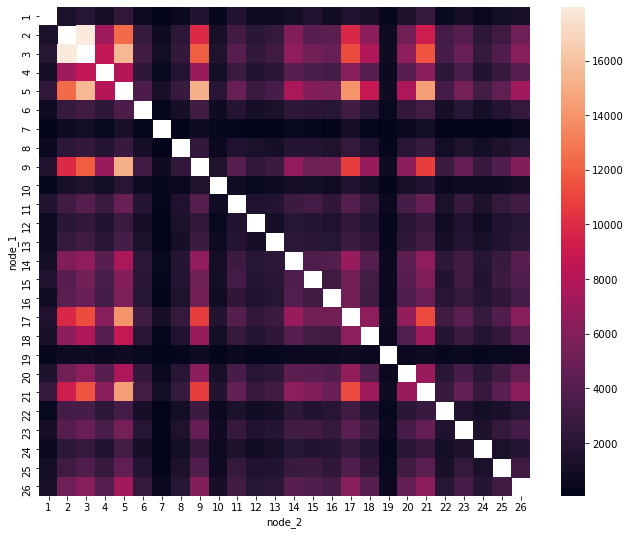

In [87]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(edges_df)
plt.show()